In [296]:
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
import scienceplots
import pdb
import os
import pandas as pd
import torch.nn.functional as F
import torch
import timm
from torchvision.models import resnet50, vgg19, inception_v3, densenet121, wide_resnet50_2

# plt.style.use(['science', 'ieee', 'no-latex'])
# plt.style.use(['science', 'no-latex'])
plt.style.use(['science'])

In [300]:
a = torch.tensor([[0.1, 0.9, 0]], dtype=torch.float32)
b = torch.tensor([[0, 1, 0]], dtype=torch.float32)
F.cosine_similarity(a, b)

tensor([0.9939])

In [83]:
timm.list_models(['*inception*'])

['adv_inception_v3',
 'ens_adv_inception_resnet_v2',
 'gluon_inception_v3',
 'inception_resnet_v2',
 'inception_v3',
 'inception_v4',
 'tf_inception_v3']

In [306]:
data_dir = './evaluation'
model_names = ['resnet50', 'densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3', ]
# methods = ['DI-FGSM', 'Poincare', 'MI-FGSM', 'TI-FGSM', 'VMI-FGSM', 'VNI-FGSM', 'SSA', 'SIT', 'BAP']
methods = ['MI-FGSM', 'NI-FGSM', 'DI-FGSM', 'TI-FGSM', 'DEM', 'Admix',  'CFM', 'SIT', 'LBAP', 'LBAP-Conv']
# methods = ['MI-FGSM', 'NI-FGSM', 'DI-FGSM', 'TI-FGSM', 'DEM', 'Admix',  'SIT', 'LBAP']
markers = ['o', 'D', 's', '^', '*', 'v', 'h', '<', 'p',  '>', 'X', '2', '1']
colors = ['blue', 'limegreen', 'c', 'm', 'y', 'darkviolet', 'purple', 'orange', 'pink', 'olive', 'red']
np.eps = np.finfo(np.float32).eps

In [302]:
def extract_items(df, fr, to):    
    frs = df[df[2] == fr]
    tos = frs[frs[3] == to]
    args = tos[0]
    fsucs = tos[4]
    tsucs = tos[5]
    return args, fsucs, tsucs

def extract_items_with_method(df, fr, to, m):
    frs = df[df[2] == fr]
    tos = frs[frs[3] == to]
    ms = tos[tos[1] == m]
    args = ms[0]
    fsucs = ms[4]
    tsucs = ms[5]
    return args, fsucs, tsucs

def replace_model(s):
    s = s.replace('wide_resnet50_2', 'WRN50-2')
    s = s.replace('resnet50', 'RN-50')
    s = s.replace('vgg19', 'VGG-19')
    s = s.replace('inception_v3', 'Inc-v3')
    s = s.replace('densenet121', 'DN-121')
    return s

def replace_method(s):
    if s == 'DI-FGSM':
        return 'DIM'
    elif s == 'Poincare':
        return 'Po-TRIP'
    elif s == 'MI-FGSM':
        return 'MI'
    elif s == 'NI-FGSM':
        return 'NI'
    elif s == 'TI-FGSM':
        return 'TIM'
    elif s == 'VMI-FGSM':
        return 'VMI'
    elif s == 'VNI-FGSM':
        return 'VNI'
    elif s == 'BAP':
        return r'$\textbf{IDAA}$'
    elif s == 'LBAP':
        return 'TLD-M'
    elif s == 'LBAP-Conv':
        return 'TLD-C'
    elif s == 'CFM':
        return 'CFM-RDI'
    return s

# Steps

In [314]:
file_path = os.path.join(data_dir, 'dsteps_evaluation.csv')
df = pd.read_csv(file_path, header=None)
alpha = 0.9

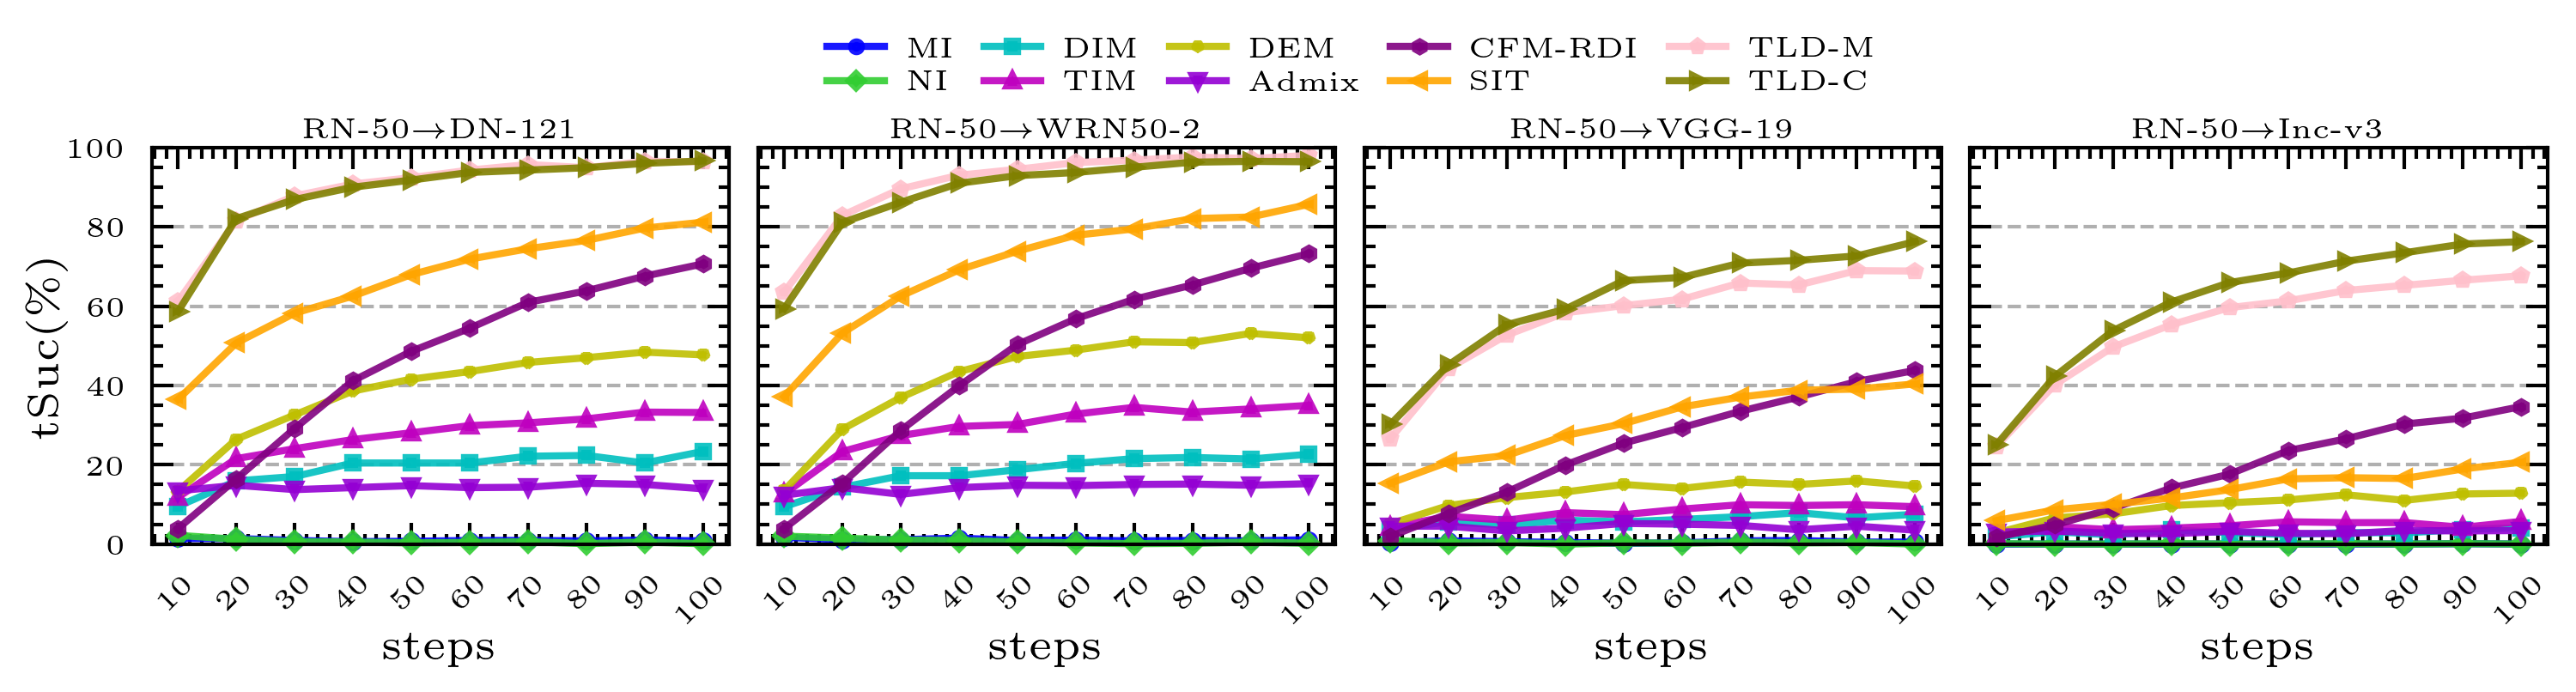

In [315]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
dummy_labels = ['', '', '', '', '' , '']
plt.rcParams['text.usetex'] = True

colormap = plt.cm.nipy_spectral
for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        ax = plt.subplot(1, len(tgt_models), j+1)
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.15, 1.1), fontsize=4, ncol=5, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
                plt.yticks(yticks, fontsize=4)
            else:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.yticks(yticks, labels=dummy_labels)
            plt.ylim(-0.01, 100.)
            plt.grid(True, axis='y', linestyle='--', which='major')
            plt.xticks(args, fontsize=4, rotation=45)
            plt.xlabel('steps', fontsize=6, labelpad=0)
            plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('steps_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

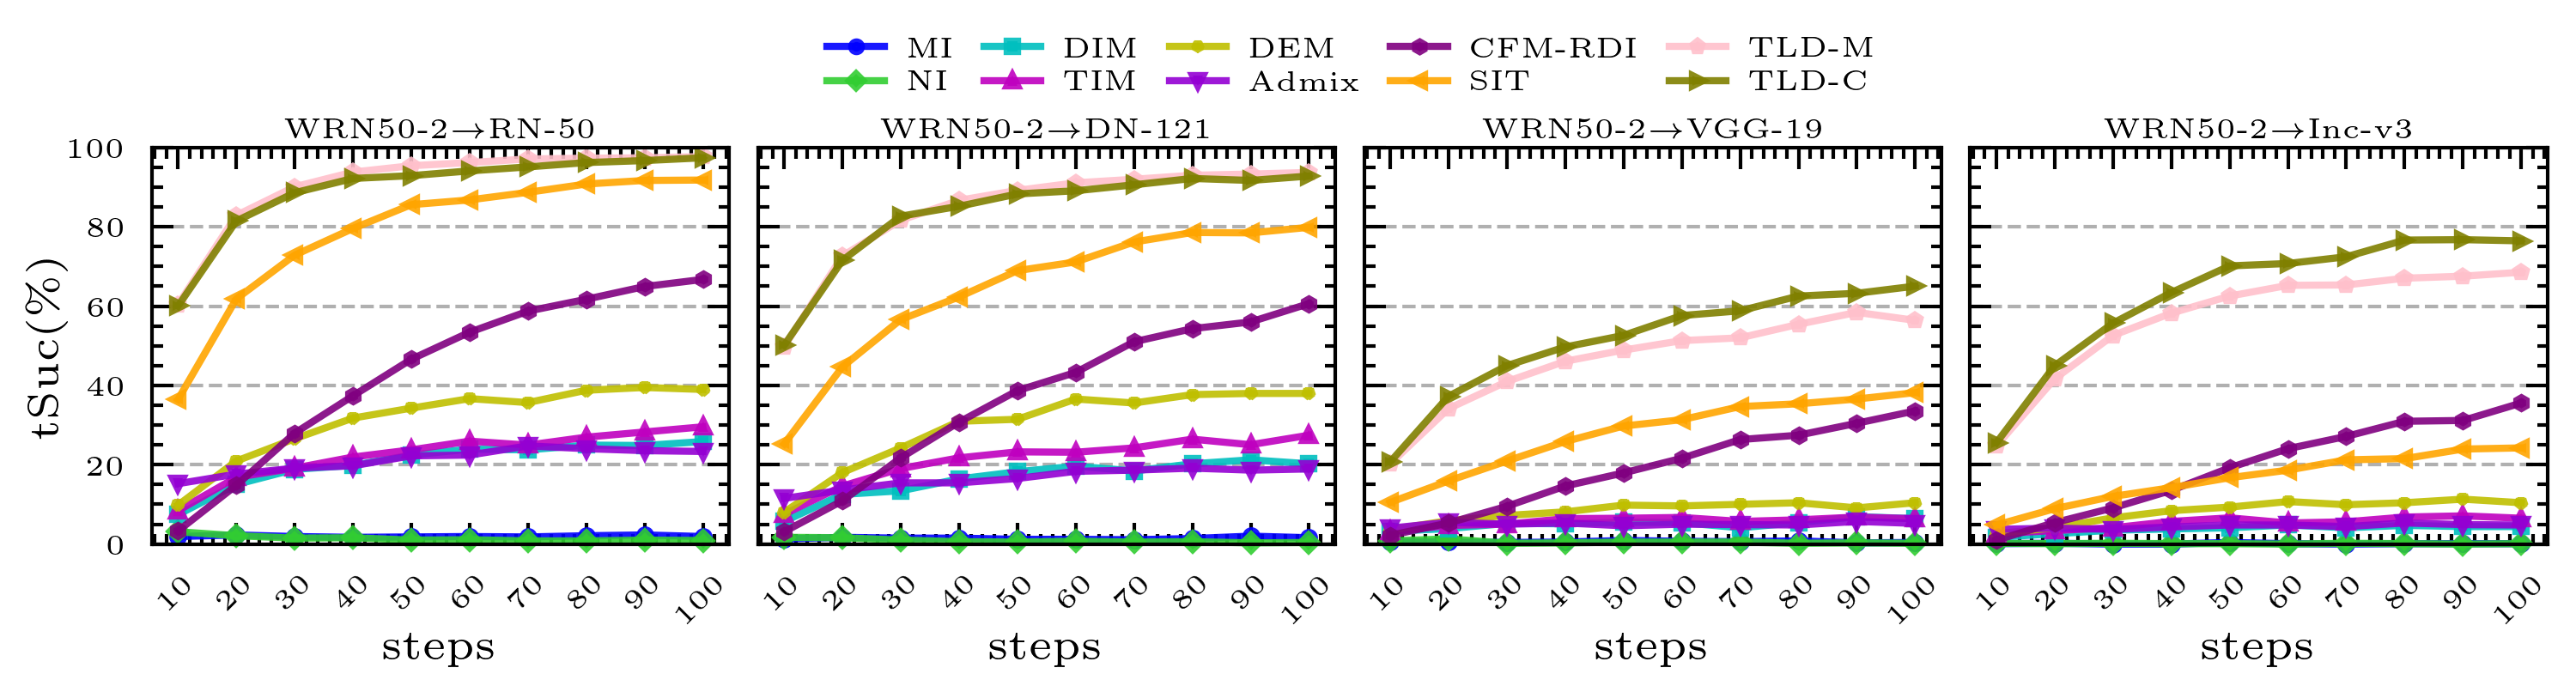

In [316]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
dummy_labels = ['', '', '', '', '' , '']
plt.rcParams['text.usetex'] = True

colormap = plt.cm.nipy_spectral
for i, src_name in enumerate(['wide_resnet50_2']):
    tgt_models = ['resnet50', 'densenet121', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        ax = plt.subplot(1, len(tgt_models), j+1)
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.15, 1.1), fontsize=4, ncol=5, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
                plt.yticks(yticks, fontsize=4)
            else:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.yticks(yticks, labels=dummy_labels)
            plt.ylim(-0.01, 100.)
            plt.grid(True, axis='y', linestyle='--', which='major')
            plt.xticks(args, fontsize=4, rotation=45)
            plt.xlabel('steps', fontsize=6, labelpad=0)
            plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('steps_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

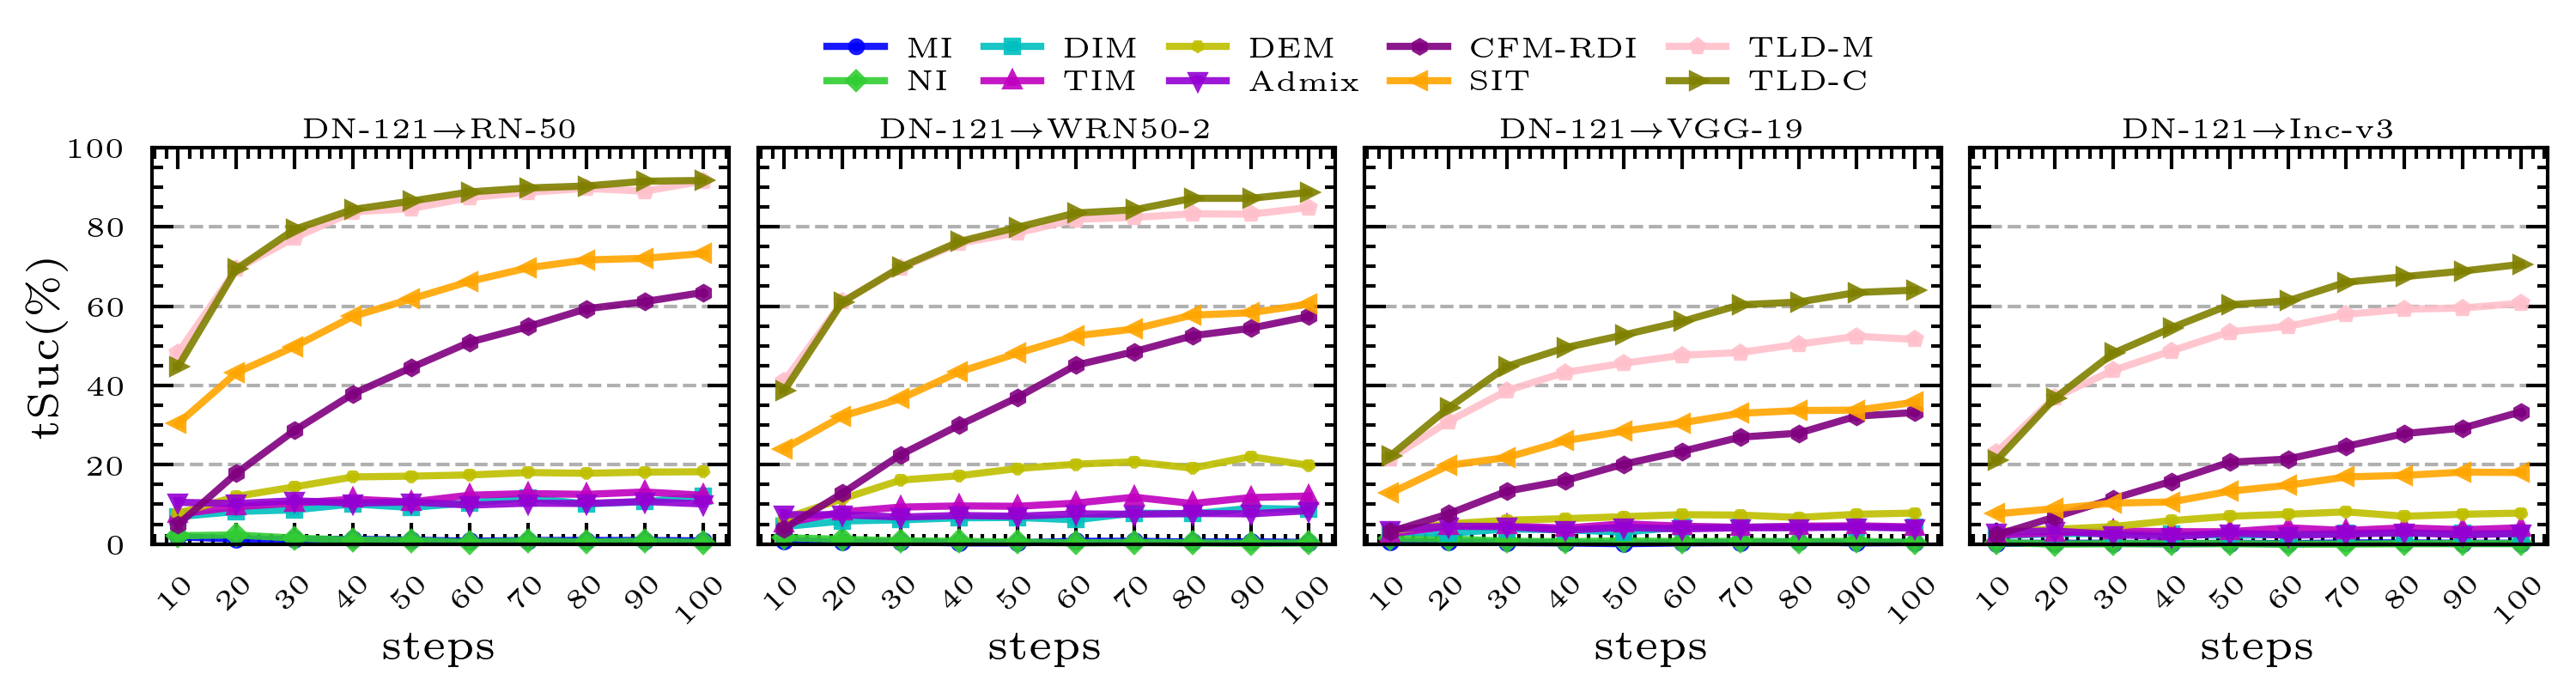

In [317]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
dummy_labels = ['', '', '', '', '' , '']
plt.rcParams['text.usetex'] = True

colormap = plt.cm.nipy_spectral
for i, src_name in enumerate(['densenet121']):
    tgt_models = ['resnet50', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        ax = plt.subplot(1, len(tgt_models), j+1)
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.15, 1.1), fontsize=4, ncol=5, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
                plt.yticks(yticks, fontsize=4)
            else:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.yticks(yticks, labels=dummy_labels)
            plt.ylim(-0.01, 100.)
            plt.grid(True, axis='y', linestyle='--', which='major')
            plt.xticks(args, fontsize=4, rotation=45)
            plt.xlabel('steps', fontsize=6, labelpad=0)
            plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('steps_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

# EPS

In [303]:
file_path = os.path.join(data_dir, 'deps_evaluation.csv')
df = pd.read_csv(file_path, header=None)

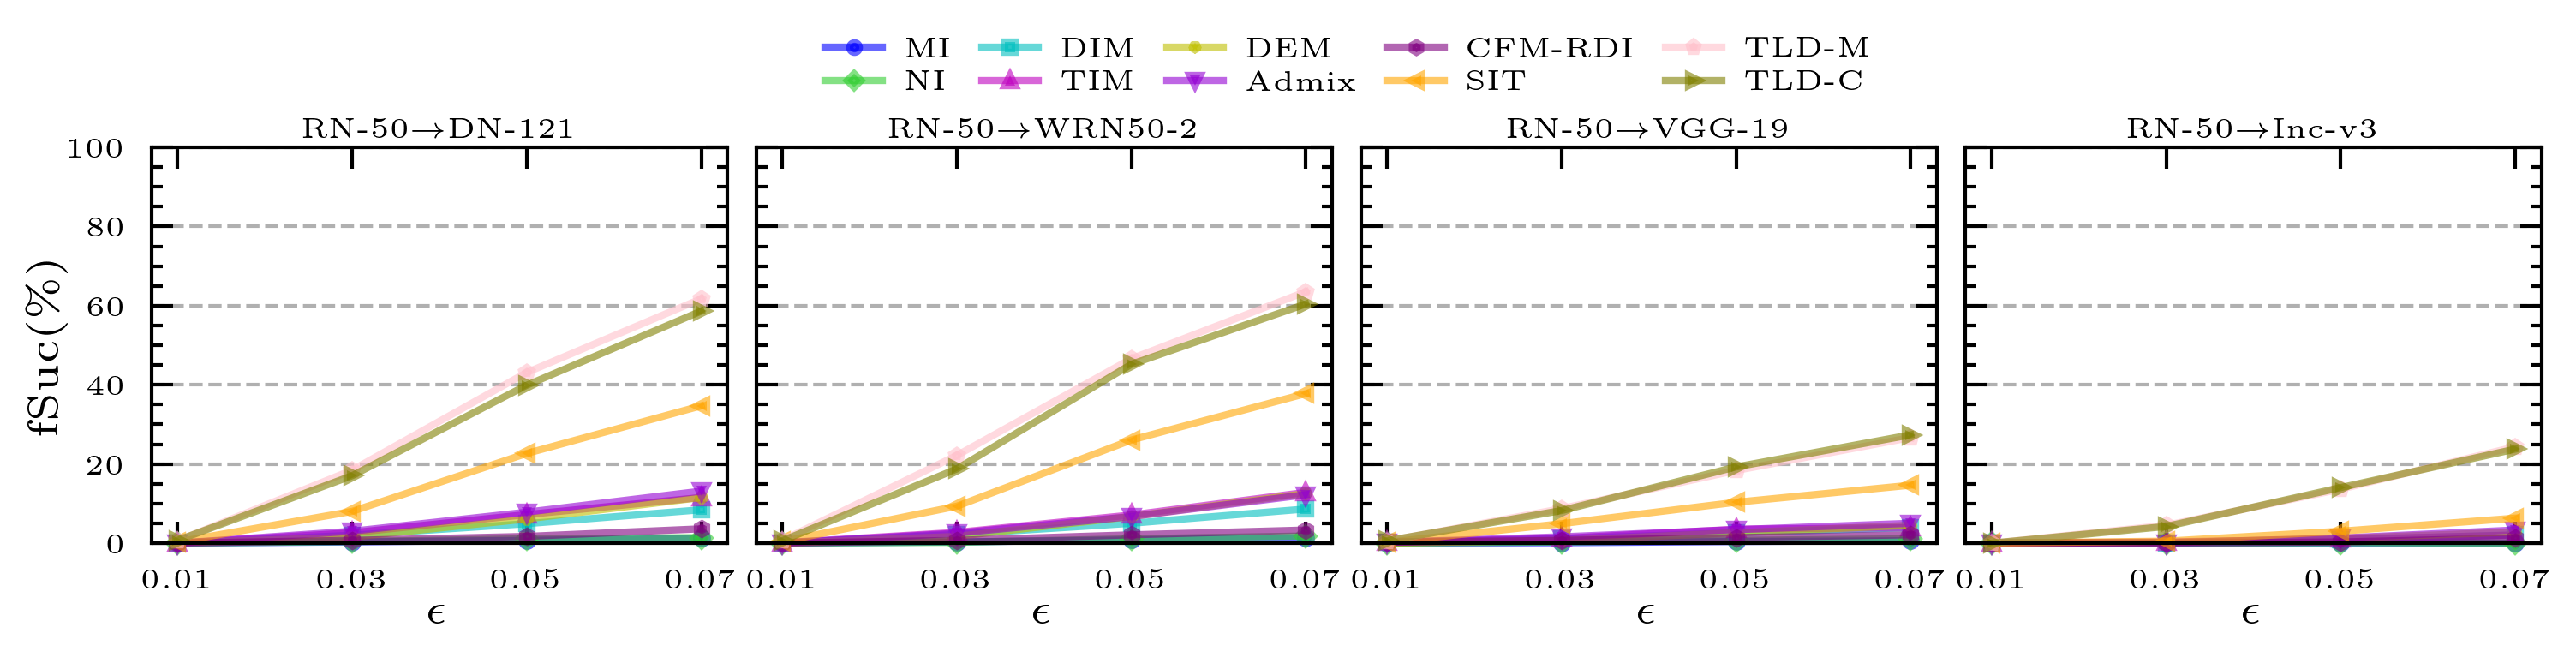

In [307]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

colormap = plt.cm.nipy_spectral
for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        plt.subplot(1, len(tgt_models), 1+j)
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy() + np.eps
            tsucs = tsucs.to_numpy() + np.eps
            idxes = args.argsort()
            if j == 0:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.15, 1.1), fontsize=4, ncol=5, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('fSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args, fontsize=4)
        plt.xlabel(r'$\epsilon$', fontsize=6, labelpad=0)
        plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('eps_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

In [308]:
for i, src_name in enumerate(['resnet50']):
    tgt_models = ['resnet50', 'densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            idxes = args.argsort()
            print(src_name, '->', tgt_name, m, tsucs[idxes][-1] * 100.0)

resnet50 -> resnet50 MI-FGSM 97.8
resnet50 -> resnet50 NI-FGSM 96.59
resnet50 -> resnet50 DI-FGSM 92.78999999999999
resnet50 -> resnet50 TI-FGSM 93.78999999999999
resnet50 -> resnet50 DEM 75.94999999999999
resnet50 -> resnet50 Admix 99.2
resnet50 -> resnet50 CFM 34.37
resnet50 -> resnet50 SIT 99.3
resnet50 -> resnet50 LBAP 99.7
resnet50 -> resnet50 LBAP-Conv 99.2
resnet50 -> densenet121 MI-FGSM 1.2
resnet50 -> densenet121 NI-FGSM 1.4000000000000001
resnet50 -> densenet121 DI-FGSM 8.42
resnet50 -> densenet121 TI-FGSM 11.52
resnet50 -> densenet121 DEM 11.52
resnet50 -> densenet121 Admix 13.13
resnet50 -> densenet121 CFM 3.61
resnet50 -> densenet121 SIT 34.67
resnet50 -> densenet121 LBAP 61.72
resnet50 -> densenet121 LBAP-Conv 58.620000000000005
resnet50 -> wide_resnet50_2 MI-FGSM 1.4000000000000001
resnet50 -> wide_resnet50_2 NI-FGSM 1.7999999999999998
resnet50 -> wide_resnet50_2 DI-FGSM 8.62
resnet50 -> wide_resnet50_2 TI-FGSM 12.83
resnet50 -> wide_resnet50_2 DEM 12.53
resnet50 -> wide

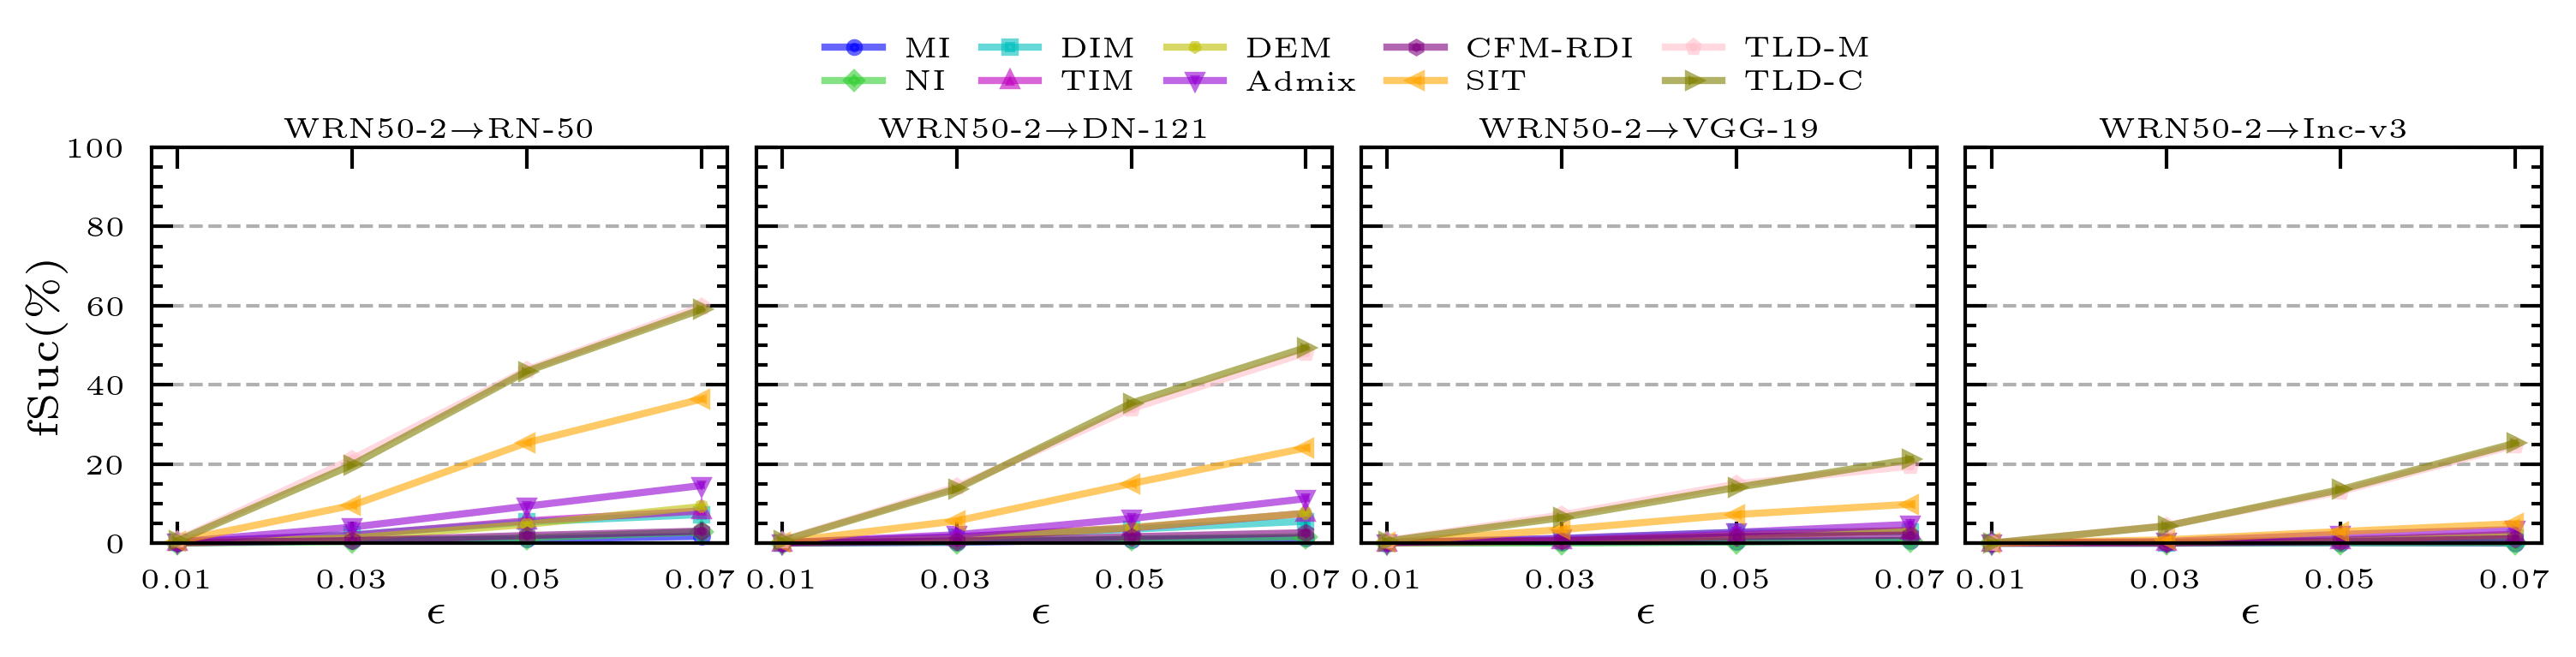

In [309]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

colormap = plt.cm.nipy_spectral
for i, src_name in enumerate(['wide_resnet50_2']):
    tgt_models = ['resnet50', 'densenet121',  'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        plt.subplot(1, len(tgt_models), 1+j)
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy() + np.eps
            tsucs = tsucs.to_numpy() + np.eps
            idxes = args.argsort()
            if j == 0:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.15, 1.1), fontsize=4, ncol=5, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('fSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args, fontsize=4)
        plt.xlabel(r'$\epsilon$', fontsize=6, labelpad=0)
        plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('eps_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

In [311]:
for i, src_name in enumerate(['densenet121']):
    tgt_models = ['resnet50', 'densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            idxes = args.argsort()
            print(src_name, '->', tgt_name, m, tsucs[idxes][-1] * 100.0)

densenet121 -> resnet50 MI-FGSM 1.4000000000000001
densenet121 -> resnet50 NI-FGSM 2.5100000000000002
densenet121 -> resnet50 DI-FGSM 6.01
densenet121 -> resnet50 TI-FGSM 6.510000000000001
densenet121 -> resnet50 DEM 7.82
densenet121 -> resnet50 Admix 10.22
densenet121 -> resnet50 CFM 4.81
densenet121 -> resnet50 SIT 31.06
densenet121 -> resnet50 LBAP 48.5
densenet121 -> resnet50 LBAP-Conv 43.99
densenet121 -> densenet121 MI-FGSM 99.7
densenet121 -> densenet121 NI-FGSM 98.9
densenet121 -> densenet121 DI-FGSM 98.6
densenet121 -> densenet121 TI-FGSM 99.0
densenet121 -> densenet121 DEM 94.39
densenet121 -> densenet121 Admix 99.8
densenet121 -> densenet121 CFM 58.120000000000005
densenet121 -> densenet121 SIT 100.0
densenet121 -> densenet121 LBAP 100.0
densenet121 -> densenet121 LBAP-Conv 99.7
densenet121 -> wide_resnet50_2 MI-FGSM 1.2
densenet121 -> wide_resnet50_2 NI-FGSM 1.7000000000000002
densenet121 -> wide_resnet50_2 DI-FGSM 4.61
densenet121 -> wide_resnet50_2 TI-FGSM 5.41
densenet12

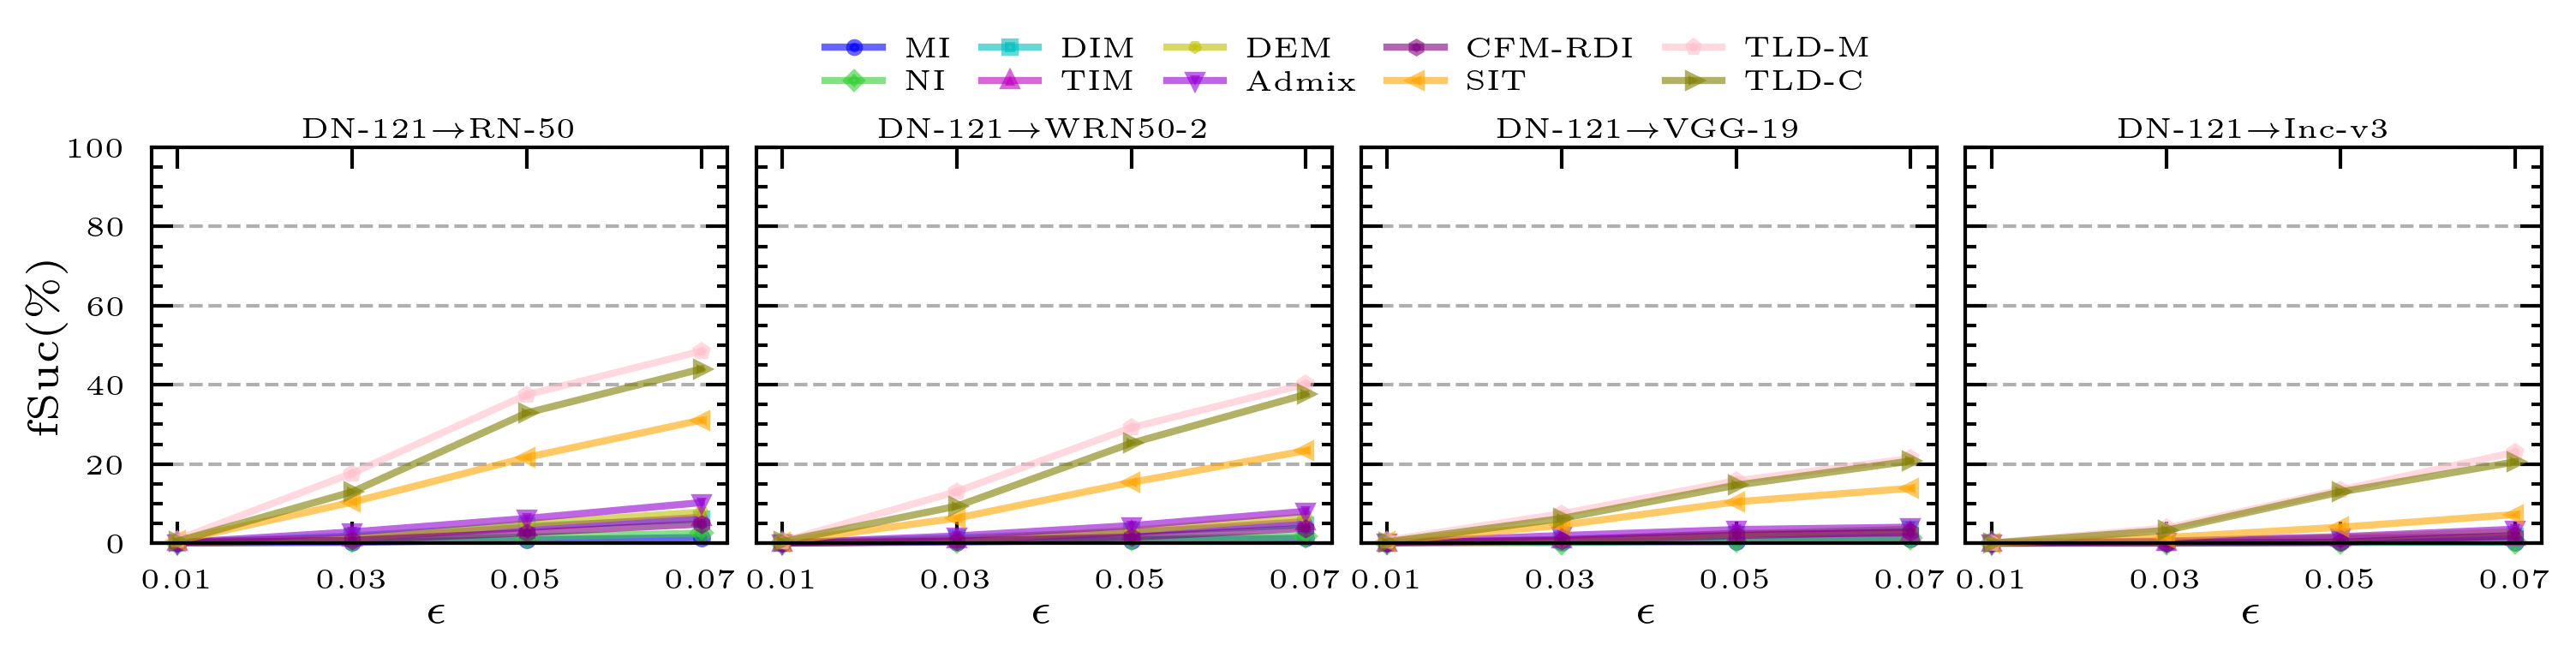

In [312]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

colormap = plt.cm.nipy_spectral
for i, src_name in enumerate(['densenet121']):
    tgt_models = ['resnet50', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        plt.subplot(1, len(tgt_models), 1+j)
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy() + np.eps
            tsucs = tsucs.to_numpy() + np.eps
            idxes = args.argsort()
            if j == 0:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.15, 1.1), fontsize=4, ncol=5, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('fSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args, fontsize=4)
        plt.xlabel(r'$\epsilon$', fontsize=6, labelpad=0)
        plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('eps_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

In [313]:
for i, src_name in enumerate(['wide_resnet50_2']):
    tgt_models = ['resnet50', 'densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            idxes = args.argsort()
            print(src_name, '->', tgt_name, m, tsucs[idxes][-1] * 100.0)

wide_resnet50_2 -> resnet50 MI-FGSM 1.7000000000000002
wide_resnet50_2 -> resnet50 NI-FGSM 2.81
wide_resnet50_2 -> resnet50 DI-FGSM 7.21
wide_resnet50_2 -> resnet50 TI-FGSM 8.12
wide_resnet50_2 -> resnet50 DEM 9.22
wide_resnet50_2 -> resnet50 Admix 14.530000000000001
wide_resnet50_2 -> resnet50 CFM 3.01
wide_resnet50_2 -> resnet50 SIT 36.370000000000005
wide_resnet50_2 -> resnet50 LBAP 59.72
wide_resnet50_2 -> resnet50 LBAP-Conv 59.019999999999996
wide_resnet50_2 -> densenet121 MI-FGSM 1.2
wide_resnet50_2 -> densenet121 NI-FGSM 1.6
wide_resnet50_2 -> densenet121 DI-FGSM 5.510000000000001
wide_resnet50_2 -> densenet121 TI-FGSM 7.5200000000000005
wide_resnet50_2 -> densenet121 DEM 7.5200000000000005
wide_resnet50_2 -> densenet121 Admix 11.219999999999999
wide_resnet50_2 -> densenet121 CFM 2.6100000000000003
wide_resnet50_2 -> densenet121 SIT 24.05
wide_resnet50_2 -> densenet121 LBAP 48.1
wide_resnet50_2 -> densenet121 LBAP-Conv 49.4
wide_resnet50_2 -> wide_resnet50_2 MI-FGSM 90.78
wide_r

# Group Size

In [318]:
file_path = os.path.join(data_dir, 'dn_evaluation.csv')
df = pd.read_csv(file_path, header=None)
methods = ['SIT', 'LBAP', 'LBAP-Conv']
markers = ['<', 'p',  '>', 'X', '2', '1']
colors = ['orange', 'pink', 'olive', 'red']

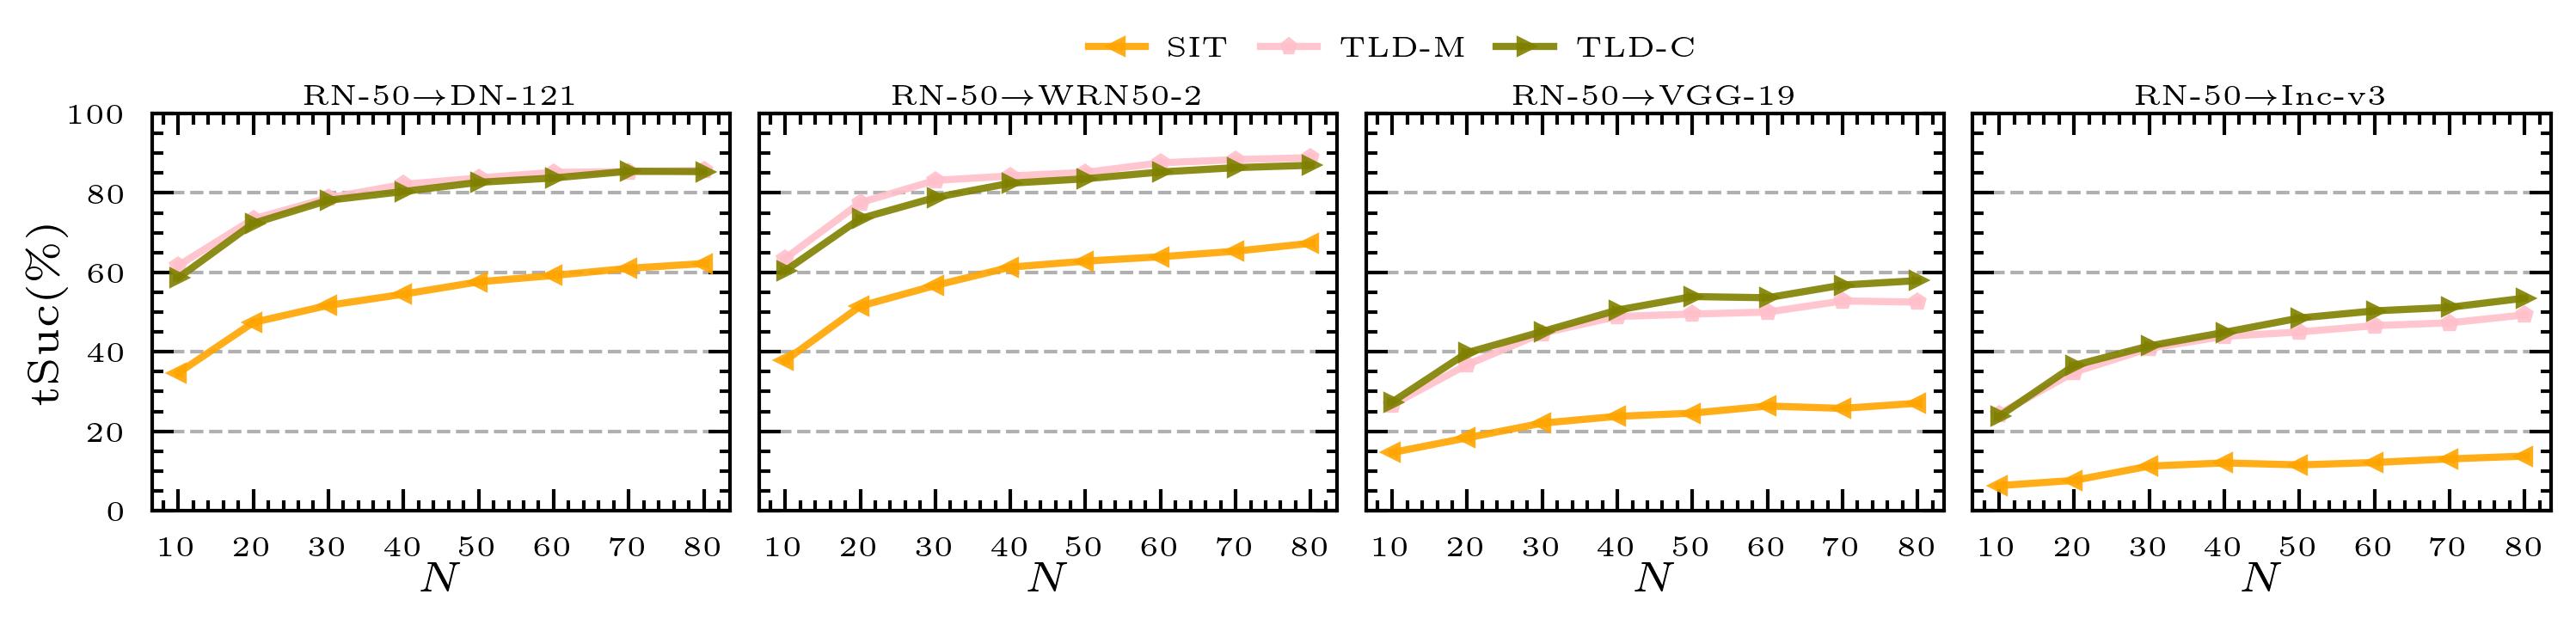

In [319]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        plt.subplot(1, len(tgt_models), 1+j)
        
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            idxes = args.argsort()
            if j == 0:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.6, 1.1), fontsize=4, ncol=6, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                plt.yticks(yticks, labels=dummy_labels)
                
            plt.ylim(-0.01, 100.)
            plt.grid(True, axis='y', linestyle='--', which='major')
            plt.xticks(args, fontsize=4)
            plt.xlabel(r'$N$', fontsize=6, labelpad=0)
            plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('n_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

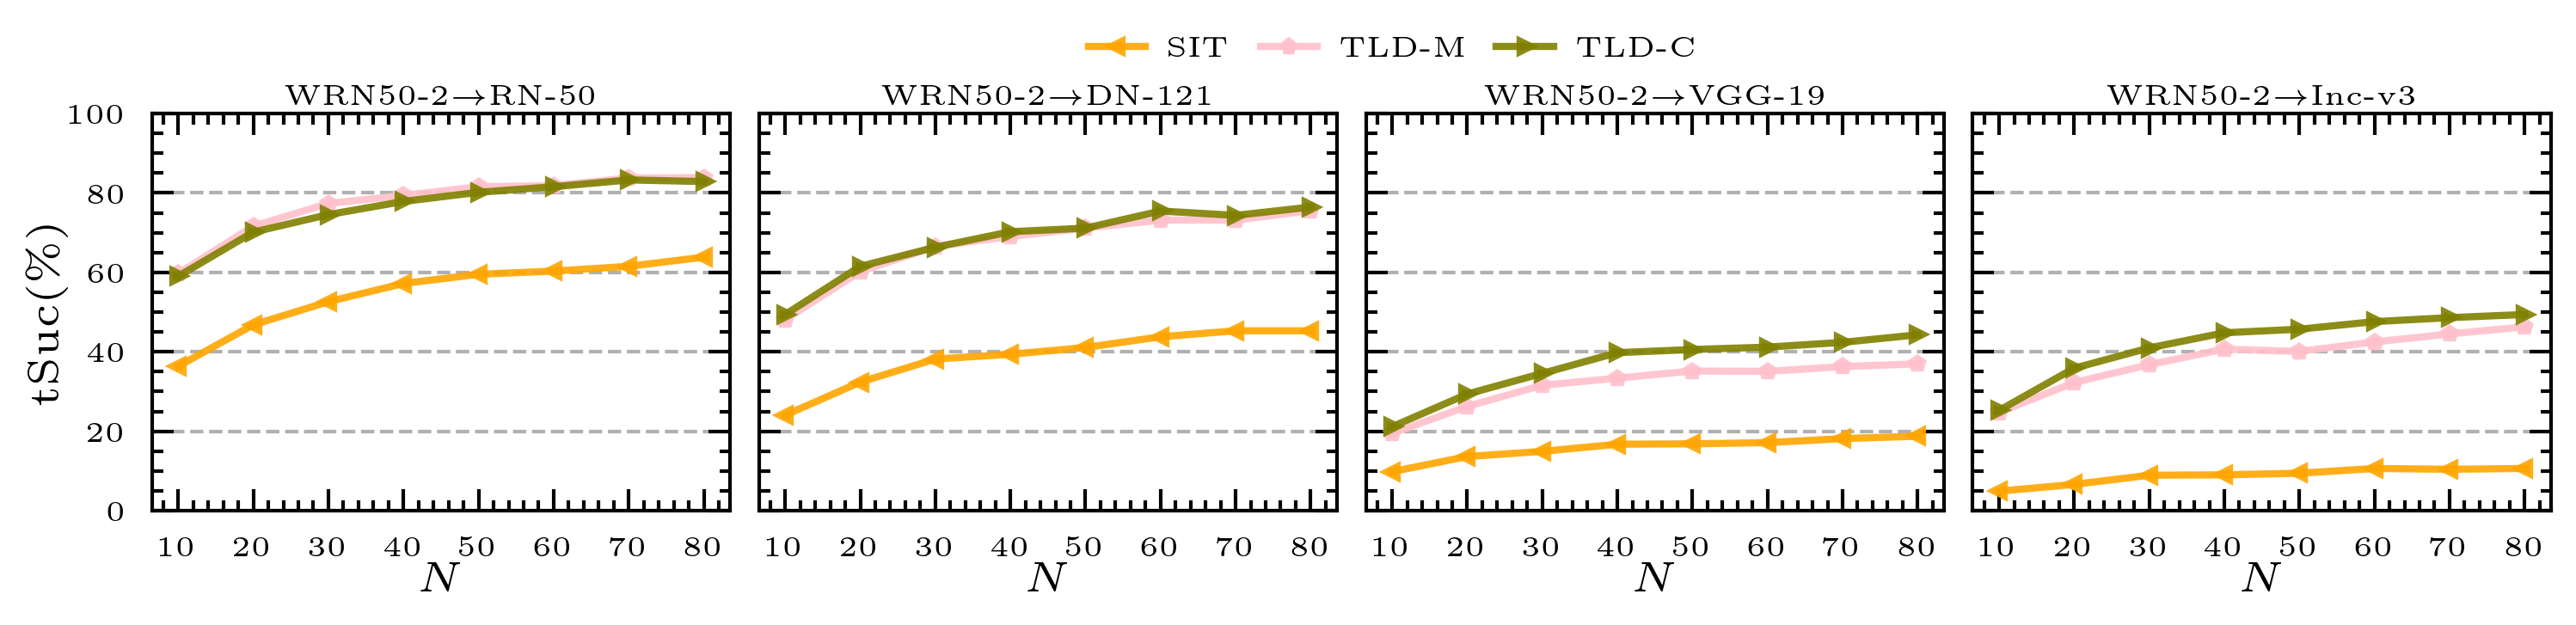

In [320]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['wide_resnet50_2']):
    tgt_models = ['resnet50', 'densenet121',  'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        plt.subplot(1, len(tgt_models), 1+j)
        
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            idxes = args.argsort()
            if j == 0:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.6, 1.1), fontsize=4, ncol=6, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                plt.yticks(yticks, labels=dummy_labels)
                
            plt.ylim(-0.01, 100.)
            plt.grid(True, axis='y', linestyle='--', which='major')
            plt.xticks(args, fontsize=4)
            plt.xlabel(r'$N$', fontsize=6, labelpad=0)
            plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('n_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

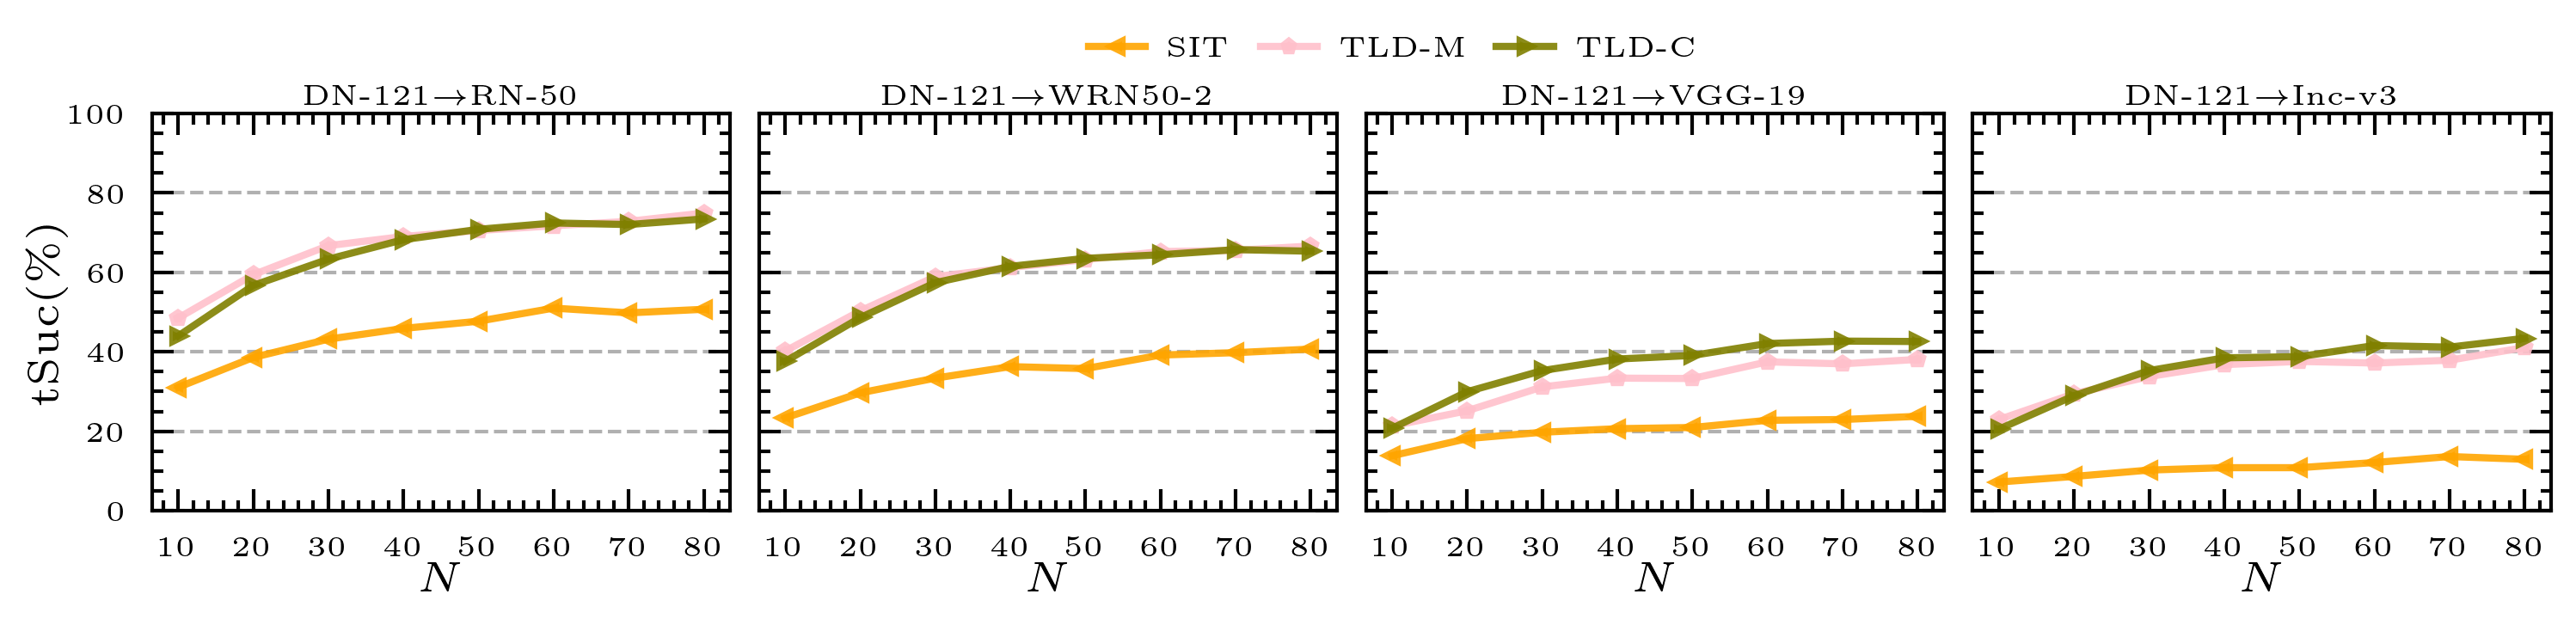

In [321]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['densenet121']):
    tgt_models = ['resnet50', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    for j, tgt_name in enumerate(tgt_models):
        plt.subplot(1, len(tgt_models), 1+j)
        
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            idxes = args.argsort()
            if j == 0:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, label=replace_method(m), 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                
                plt.legend(loc=(1.6, 1.1), fontsize=4, ncol=6, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args[idxes], tsucs[idxes] * 100.0, 
                    markersize=1.5, marker=markers[k], clip_on=False, alpha=alpha, color=colors[k])
                plt.yticks(yticks, labels=dummy_labels)
                
            plt.ylim(-0.01, 100.)
            plt.grid(True, axis='y', linestyle='--', which='major')
            plt.xticks(args, fontsize=4)
            plt.xlabel(r'$N$', fontsize=6, labelpad=0)
            plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('n_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

# Mixup

In [334]:
file_path = os.path.join(data_dir, 'dmixup_evaluation.csv')
df = pd.read_csv(file_path, header=None)
methods = ['LBAP']
markers = ['<', 'p',  '>', 'X', '2', '1']
colors = ['orange', 'pink', 'olive', 'red']
alpha = 0.6

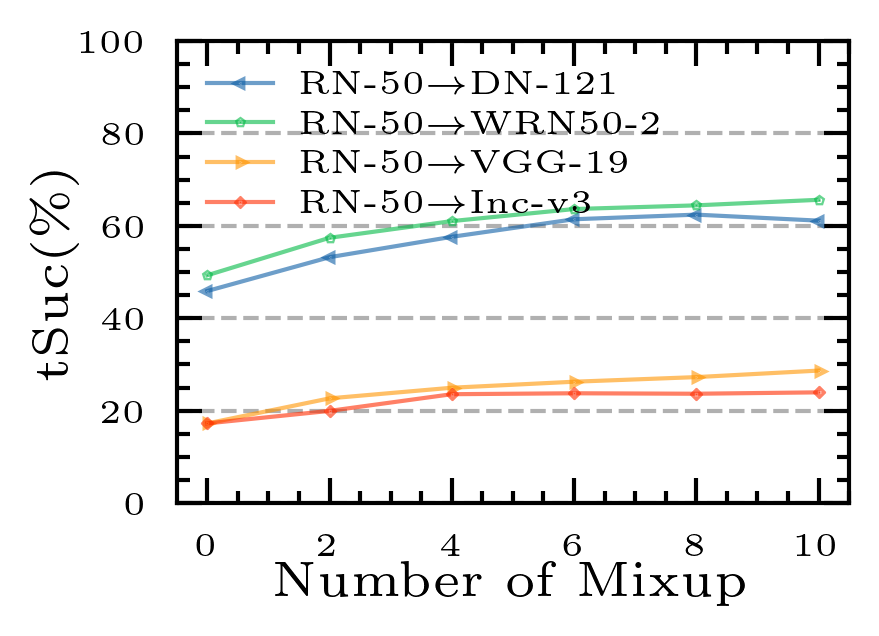

In [335]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args[::2], fontsize=4)
        plt.xlabel('Number of Mixup', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        # plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('mixup_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

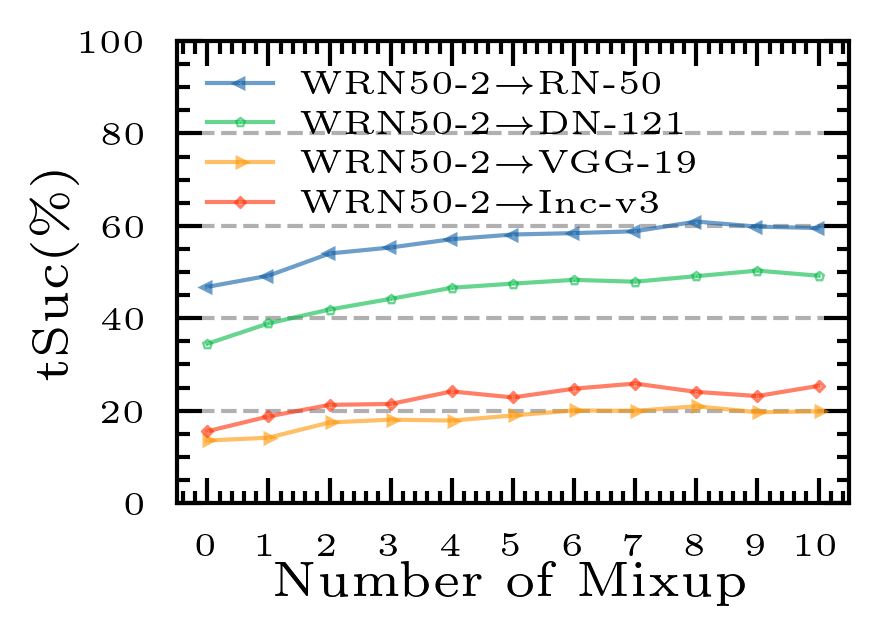

In [336]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['wide_resnet50_2']):
    tgt_models = ['resnet50', 'densenet121',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args, fontsize=4)
        plt.xlabel('Number of Mixup', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        # plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('mixup_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

# Kernal Size

In [337]:
file_path = os.path.join(data_dir, 'dkern_evaluation.csv')
df = pd.read_csv(file_path, header=None)
methods = ['LBAP-Conv']
markers = ['<', 'p',  '>', 'X', '2', '1']
colors = ['orange', 'pink', 'olive', 'red']
alpha = 0.6

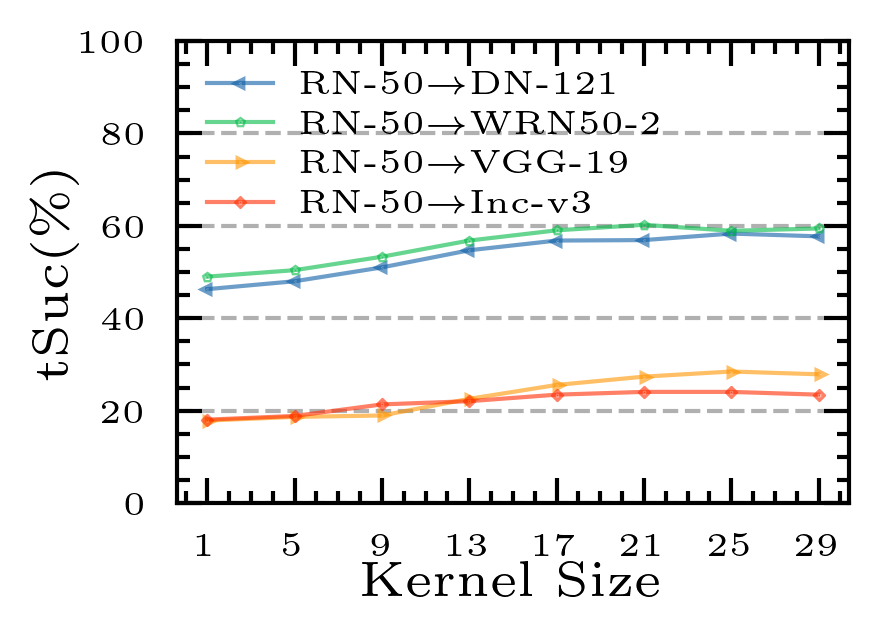

In [338]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args[::2], fontsize=4)
        plt.xlabel('Kernel Size', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        # plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('kern_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

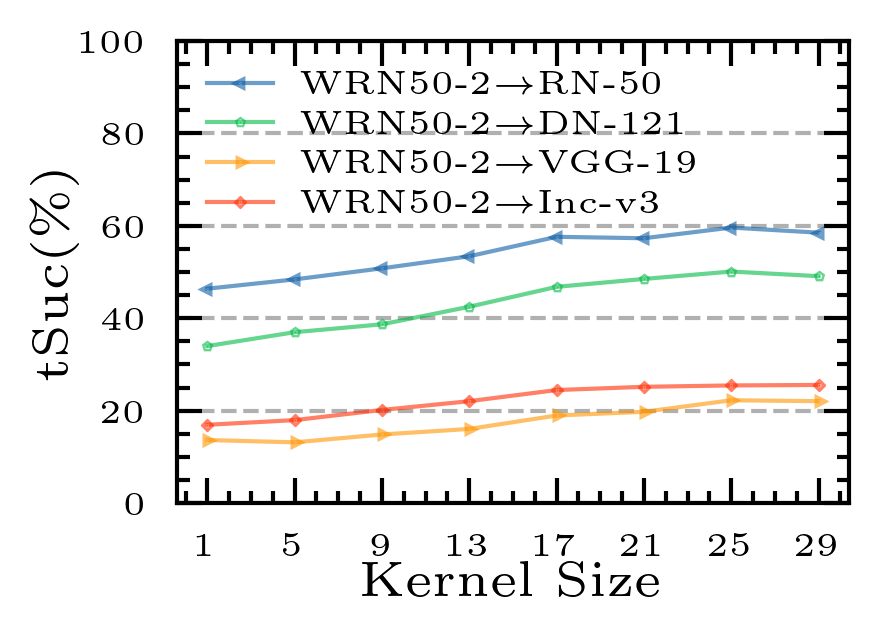

In [339]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['wide_resnet50_2']):
    tgt_models = ['resnet50', 'densenet121',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args[::2], fontsize=4)
        plt.xlabel('Kernel Size', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        # plt.title(replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('kern_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

# Layer

In [285]:
file_path = os.path.join(data_dir, 'dlayer_evaluation.csv')
df = pd.read_csv(file_path, header=None)
methods = ['LBAP']
markers = ['<', 'p',  '>', 'X', '2', '1']
colors = ['orange', 'pink', 'olive', 'red']
alpha = 0.6

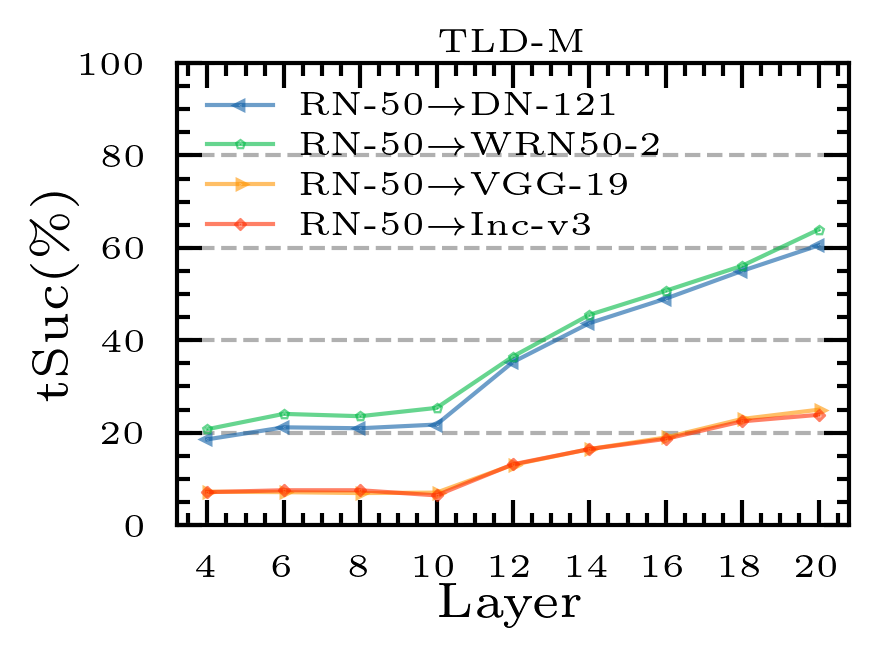

In [286]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args[::2], fontsize=4)
        plt.xlabel('Layer', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        plt.title('TLD-M', fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('mixup_layer_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

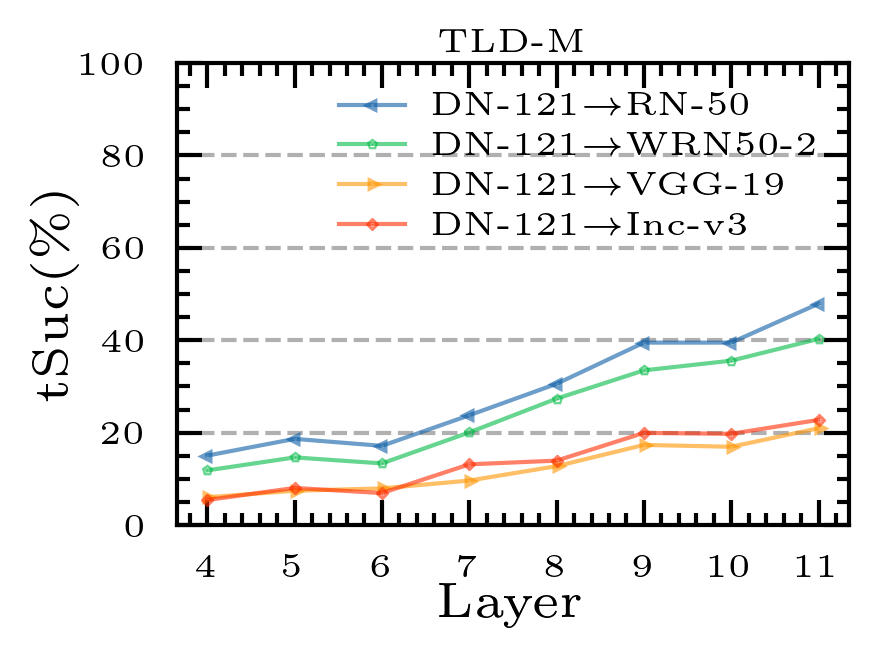

In [287]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['densenet121']):
    tgt_models = ['resnet50', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args, fontsize=4)
        plt.xlabel('Layer', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        plt.title('TLD-M', fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('mixup_layer_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

In [288]:
file_path = os.path.join(data_dir, 'dlayer_evaluation.csv')
df = pd.read_csv(file_path, header=None)
methods = ['LBAP-Conv']
markers = ['<', 'p',  '>', 'X', '2', '1']
colors = ['orange', 'pink', 'olive', 'red']
alpha = 0.6

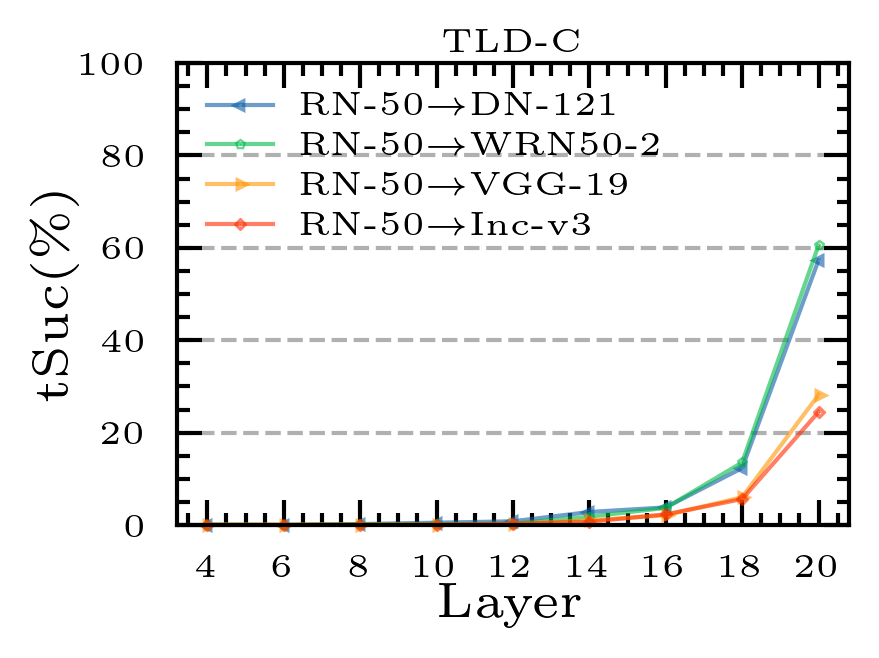

In [289]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['resnet50']):
    tgt_models = ['densenet121', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy()[::2], tsucs.to_numpy()[::2] * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args[::2], fontsize=4)
        plt.xlabel('Layer', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        plt.title('TLD-C', fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('kern_layer_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

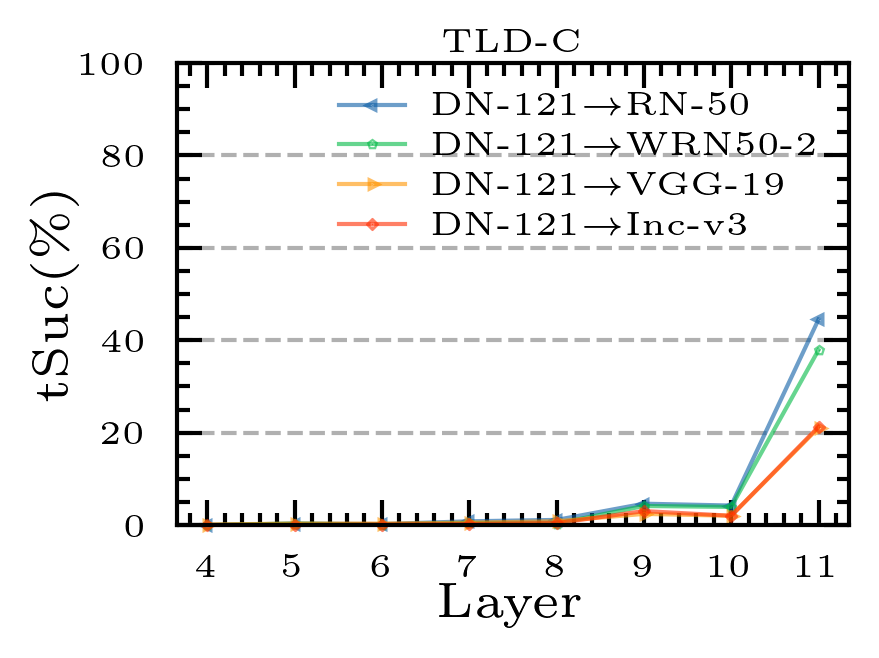

In [290]:
fig = plt.figure(figsize=(6, 1), dpi=600)
yticks = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
plt.rcParams['text.usetex'] = True

for i, src_name in enumerate(['densenet121']):
    tgt_models = ['resnet50', 'wide_resnet50_2',  'vgg19', 'inception_v3']
    plt.subplot(1, len(tgt_models), 1+i)
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            if j == 0:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name), 
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5) #, color=colors[k])
                
                plt.yticks(yticks, fontsize=4)
                plt.ylabel('tSuc(\%)', labelpad=0, fontsize=6)
            else:
                plt.plot(args.to_numpy(), tsucs.to_numpy() * 100.0, 
                         label=replace_model(src_name) + r'$\rightarrow$' + replace_model(tgt_name),
                    markersize=0.2, marker=markers[j], clip_on=False, alpha=alpha, linewidth=0.5)# color=colors[k])
                # plt.yticks(yticks, labels=dummy_labels)
                
        plt.ylim(-0.01, 100.)
        plt.grid(True, axis='y', linestyle='--', which='major')
        plt.xticks(args, fontsize=4)
        plt.xlabel('Layer', fontsize=6, labelpad=0)
        plt.legend(fontsize=4, ncol=1, frameon=False, labelspacing=0.3, 
                   columnspacing=1.0, markerscale=0.9)
        plt.title('TLD-C', fontsize=4, pad=1.2)
    break
plt.subplots_adjust(wspace=0.05)
plt.savefig('kern_layer_{}.pdf'.format(src_name),
        dpi = 600,
        bbox_inches = 'tight')
plt.show()

# LINT

In [208]:
file_path = os.path.join(data_dir, 'dlint_evaluation.csv')
df = pd.read_csv(file_path, header=None)

In [214]:
for i, src_name in enumerate(['resnet50']):
    tgt_models = ['resnet50', 'densenet121', 'wide_resnet50_2', 'vgg19', 'inception_v3']
    methods = ['LINTDEM', 'LINTAdmix', 'LINTSIT']
    for j, tgt_name in enumerate(tgt_models):
        for k, m in enumerate(methods):
            args, fsucs, tsucs = extract_items_with_method(df, src_name, tgt_name, m)
            args = args.to_numpy()
            fsucs = fsucs.to_numpy()
            tsucs = tsucs.to_numpy()
            print(src_name, '->', tgt_name, m, tsucs * 100.0)

resnet50 -> resnet50 LINTDEM []
resnet50 -> resnet50 LINTAdmix []
resnet50 -> resnet50 LINTSIT []
resnet50 -> densenet121 LINTDEM []
resnet50 -> densenet121 LINTAdmix []
resnet50 -> densenet121 LINTSIT []
resnet50 -> wide_resnet50_2 LINTDEM []
resnet50 -> wide_resnet50_2 LINTAdmix []
resnet50 -> wide_resnet50_2 LINTSIT []
resnet50 -> vgg19 LINTDEM []
resnet50 -> vgg19 LINTAdmix []
resnet50 -> vgg19 LINTSIT []
resnet50 -> inception_v3 LINTDEM []
resnet50 -> inception_v3 LINTAdmix []
resnet50 -> inception_v3 LINTSIT []
